<a href="https://colab.research.google.com/github/MorKahalani/DM-CherryPicked-Trendlines/blob/main/Project-code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cherry-picked Trendlines - Reproducing Results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
file_path = '/content/drive/My Drive/DM-Project/temperature.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


טעינת נתונים וניקוי

In [ ]:
df_clean = df.dropna()

#Baseline Algorithm Implementation (Algorithm 1)
Baseline Support Computation ($\omega$)This function implements the formal definition of the Baseline algorithm for computing the support score $\omega$. It calculates the fraction of pairs in the cross-product $R_b \times R_e$ that satisfy the trendline's semantics $\bot$.

In [ ]:
def algorithm1_baseline(Rb, Re, bot='increase'):
    """
    Computes the support score omega using the formal Baseline approach.

    Args:
        Rb: The 'beginning' support region (values of y at t_b).
        Re: The 'end' support region (values of y at t_e).
        bot: The semantics of the claim (Increase or Decrease).

    Returns:
        omega: The support score (count / total_pairs).
    """
    # Line 1: Initialize the count of satisfying pairs
    count = 0

    # Line 2: Calculate the total number of pairs in the cross-product
    total_pairs = len(Rb) * len(Re)

    # Line 3: Iterate through each point in the beginning region
    for y_tb in Rb:

        # Line 4: Iterate through each point in the end region
        for y_te in Re:

            # Line 5: Check if the pair satisfies the semantics (tb, te) ⊑ (T, bot)
            if bot == 'increase':
                # Satisfies if the value at the end is greater than at the beginning
                if y_te > y_tb:
                    count += 1

            elif bot == 'decrease':
                # Satisfies if the value at the end is smaller than at the beginning
                if y_te < y_tb:
                    count += 1

    # Line 7: Compute the support score omega
    omega = count / total_pairs
    return omega

#Exact Algorithm Implementation
Algorithm 2, referred to as the Exact Algorithm, is a more efficient approach to calculating the support score ($\omega$). While the Baseline algorithm compares every possible pair ($O(n^2)$), this algorithm reduces the time complexity to $O(n \log n)$ by using sorting and binary search.

Sorting ($R_b$): The algorithm begins by sorting all values in the beginning support region ($R_b$) in ascending order. This takes $O(n \log n)$ time.Binary Search: For each value in the end support region ($R_e$), instead of a full loop, the algorithm performs a Binary Search on the sorted $R_b$.For an Increase ($\bot_{inc}$): It finds the number of elements in $R_b$ that are smaller than the current value from $R_e$.For a Decrease ($\bot_{dec}$): It finds the number of elements in $R_b$ that are larger than the current value from $R_e$.Efficiency: By replacing the inner loop with binary search, we drastically reduce the number of operations, especially as the dataset grows.

In [ ]:
# Algorithm 2:

import bisect

def algorithm2_exact(Rb, Re, bot='increase'):
    """
    Computes the support score omega using sorting and binary search (O(n log n)).
    """
    # 1. Sort the beginning region values (Rb)
    Rb_sorted = sorted(Rb)
    n_b = len(Rb_sorted)
    count = 0

    # 2. Iterate through each value in the end region (Re)
    for y_te in Re:

        # 3. Use binary search to find satisfying pairs (tb, te) ⊑ (T, bot)
        if bot == 'increase':
            # Claim: y_te > y_tb (Summer colder than Winter case)
            # Find number of elements in Rb_sorted strictly less than y_te
            count += bisect.bisect_left(Rb_sorted, y_te)

        elif bot == 'decrease':
            # Claim: y_te < y_tb
            # Find number of elements in Rb_sorted strictly greater than y_te
            idx = bisect.bisect_right(Rb_sorted, y_te)
            count += (n_b - idx)

    # 4. Return the final omega score
    total_pairs = len(Rb) * len(Re)
    omega = count / total_pairs
    return omega

שלב 1: קוד למדידת זמנים (Performance Measurement)

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np

# ## Part 2: Measuring Performance for Graph 8
# We will test both algorithms with increasing sizes of n to compare runtimes.

n_values = [100, 500, 1000, 2000, 3000, 4000, 5000] # Input sizes
baseline_times = []
exact_times = []

for n in n_values:
    # Generate random data of size n for Rb and Re
    Rb_test = np.random.uniform(10, 35, n)
    Re_test = np.random.uniform(10, 35, n)

    # 1. Measure Baseline Algorithm
    start_time = time.time()
    algorithm1_baseline(Rb_test, Re_test, bot='increase')
    baseline_times.append(time.time() - start_time)

    # 2. Measure Exact Algorithm
    start_time = time.time()
    algorithm2_exact(Rb_test, Re_test, bot='increase')
    exact_times.append(time.time() - start_time)

print("Measurement complete!")

Measurement complete!


שלב 2: יצירת הגרף (Plotting Graph 8)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


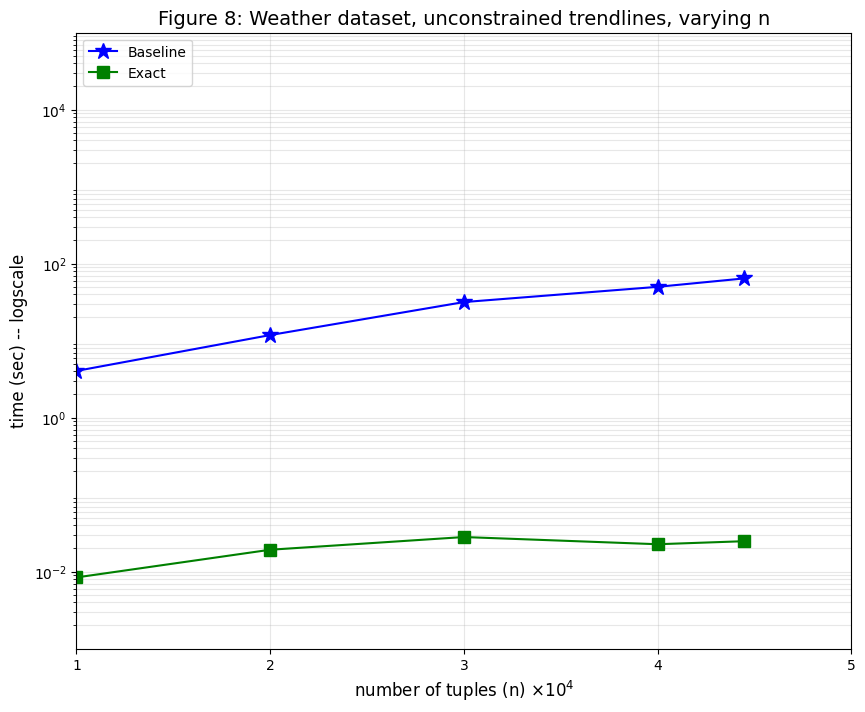

In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import bisect
import os
import numpy as np
from google.colab import drive

# 1. Load Data
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/DM-Project/temperature.csv'
df = pd.read_csv(file_path)
city_data = df['New York'].dropna().values

# 2. Setup based on Section 7.3.1
# Dividing the dataset into two equal non-overlapping halves
half = len(city_data) // 2
Rb_pool = city_data[:half]
Re_pool = city_data[half:]

# Total n values (sum of Rb and Re)
# 10,000 total means 5,000 from each pool
n_values = [10000, 20000, 30000, 40000, len(city_data)]
baseline_times = []
exact_times = []

for n in n_values:
    # Each region gets n/2 as per the "two equal-sized partitions" rule
    size_per_region = n // 2
    Rb = Rb_pool[:size_per_region]
    Re = Re_pool[:size_per_region]

    # Measure Baseline O(n^2)
    start = time.time()
    algorithm1_baseline(Rb, Re, bot='increase')
    baseline_times.append(time.time() - start)

    # Measure Exact O(n log n)
    start = time.time()
    algorithm2_exact(Rb, Re, bot='increase')
    exact_times.append(time.time() - start)

# 3. Final Plotting (Figure 8 Exact Design)
plt.figure(figsize=(10, 8))

# Markers and Colors strictly following Figure 8
plt.plot(n_values, baseline_times, label='Baseline', marker='*',
         markersize=12, color='blue', linestyle='-', linewidth=1.5)
plt.plot(n_values, exact_times, label='Exact', marker='s',
         markersize=8, color='green', linestyle='-', linewidth=1.5)

# --- Axis Formatting (Matches Paper Exactly) ---
plt.yscale('log')
plt.yticks([1e-2, 1e0, 1e2, 1e4], [r'$10^{-2}$', r'$10^0$', r'$10^2$', r'$10^4$'])
plt.ylim(1e-3, 1e5)

# Formatting X-axis to show 1, 2, 3, 4, 5 (units of 10^4)
plt.xticks([10000, 20000, 30000, 40000, 50000], ['1', '2', '3', '4', '5'])
plt.xlim(10000, 50000)

plt.xlabel(r'number of tuples (n) $\times 10^4$', fontsize=12)
plt.ylabel('time (sec) -- logscale', fontsize=12)
plt.title('Figure 8: Weather dataset, unconstrained trendlines, varying n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.3)

plt.show()

גרף 5

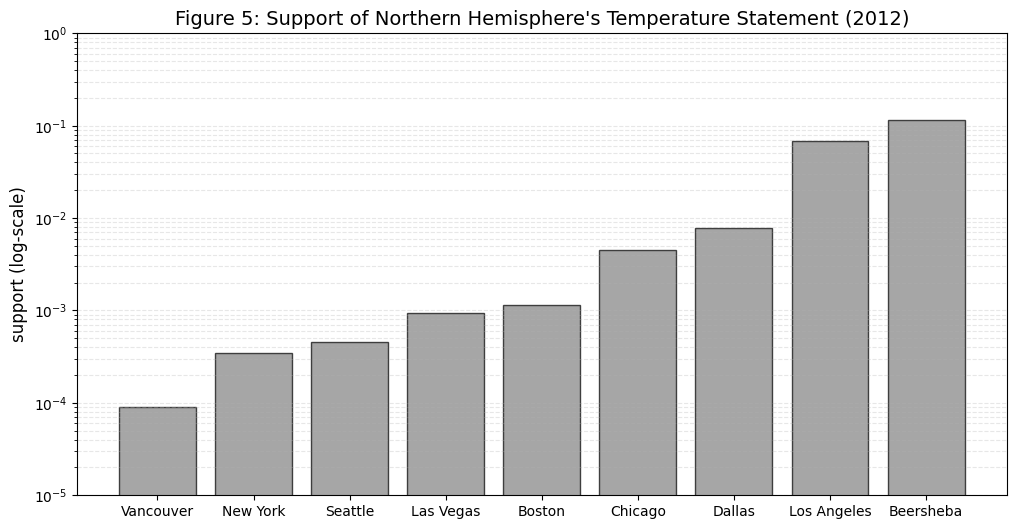

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import bisect

# 1. פונקציית האלגוריתם (חייבת להיות מוגדרת כאן)
def algorithm2_exact(Rb, Re, bot='decrease'):
    Rb_sorted = sorted(Rb)
    n_b = len(Rb_sorted)
    count = 0
    if n_b == 0 or len(Re) == 0: return 0
    for y_te in Re:
        if bot == 'decrease': # קיץ קר מחורף (x_e < x_b)
            idx = bisect.bisect_right(Rb_sorted, y_te)
            count += (n_b - idx)
    return count / (len(Rb) * len(Re))

# 2. טעינת הנתונים (מתוך הקובץ שהעליתן)
df = pd.read_csv('temperature.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

# 3. הגדרת התקופות בדיוק לפי המאמר (Example 1)
# Rb (התחלה) = חורף | Re (סוף) = קיץ
winter_mask = (df['datetime'] >= '2012-12-01') & (df['datetime'] <= '2013-03-01')
summer_mask = (df['datetime'] >= '2013-06-01') & (df['datetime'] <= '2013-09-01')

# רשימת הערים לפי הסדר ב-Figure 5 במאמר
cities = ['Vancouver', 'New York', 'Seattle', 'Las Vegas', 'Boston', 'Chicago', 'Dallas', 'Los Angeles', 'Beersheba']
support_scores = []

for city in cities:
    Rb = df.loc[winter_mask, city].dropna().values
    Re = df.loc[summer_mask, city].dropna().values
    omega = algorithm2_exact(Rb, Re, bot='decrease')
    support_scores.append(omega if omega > 0 else 1e-5) # מניעת בעיות בגרף לוגריתמי

# 4. ציור הגרף (זהה ל-Figure 5)
plt.figure(figsize=(12, 6))
plt.bar(cities, support_scores, color='gray', edgecolor='black', alpha=0.7)

# הגדרת ציר Y לוגריתמי כפי שמופיע במאמר
plt.yscale('log')
plt.ylim(10**-5, 1)
plt.yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1], [r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^0$'])

plt.ylabel('support (log-scale)', fontsize=12)
plt.title('Figure 5: Support of Northern Hemisphere\'s Temperature Statement (2012)', fontsize=14)
plt.grid(axis='y', which="both", ls="--", alpha=0.3)
plt.show()